# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_nopercolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 10, 10
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = []
    LAST_LAYER = 'block_16_project_BN'
    PREPROCESSING = tf.keras.applications.mobilenet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8301 - accuracy: 0.7287

947/947 [==============================] - 3696s 4s/step - loss: 0.8301 - accuracy: 0.7287 - val_loss: 3.3275 - val_accuracy: 0.6785
Epoch 2/200
947/947 [==============================] - 3267s 3s/step - loss: 0.7257 - accuracy: 0.7527 - val_loss: 3.8467 - val_accuracy: 0.6928
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6780 - accuracy: 0.7665

947/947 [==============================] - 3465s 4s/step - loss: 0.6780 - accuracy: 0.7665 - val_loss: 2.9828 - val_accuracy: 0.4246
Epoch 4/200
947/947 [==============================] - 3262s 3s/step - loss: 0.6434 - accuracy: 0.7784 - val_loss: 3.7283 - val_accuracy: 0.6443
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.6229 - accuracy: 0.7826

947/947 [==============================] - 3461s 4s/step - loss: 0.6229 - accuracy: 0.7826 - val_loss: 2.3188 - val_accuracy: 0.4707
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 0.5979 - accuracy: 0.7906

947/947 [==============================] - 3445s 4s/step - loss: 0.5979 - accuracy: 0.7906 - val_loss: 1.7526 - val_accuracy: 0.6036
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5819 - accuracy: 0.7937

947/947 [==============================] - 3443s 4s/step - loss: 0.5819 - accuracy: 0.7937 - val_loss: 1.1395 - val_accuracy: 0.6602
Epoch 8/200
947/947 [==============================] - 3249s 3s/step - loss: 0.5686 - accuracy: 0.7988 - val_loss: 1.1726 - val_accuracy: 0.7247
Epoch 9/200
947/947 [==============================] - ETA: 0s - loss: 0.5505 - accuracy: 0.8048

947/947 [==============================] - 3451s 4s/step - loss: 0.5505 - accuracy: 0.8048 - val_loss: 0.8150 - val_accuracy: 0.7632
Epoch 10/200
947/947 [==============================] - 3249s 3s/step - loss: 0.5390 - accuracy: 0.8085 - val_loss: 1.0367 - val_accuracy: 0.6985
Epoch 11/200
947/947 [==============================] - ETA: 0s - loss: 0.5280 - accuracy: 0.8127

947/947 [==============================] - 3438s 4s/step - loss: 0.5280 - accuracy: 0.8127 - val_loss: 0.7899 - val_accuracy: 0.7593
Epoch 12/200
947/947 [==============================] - 3242s 3s/step - loss: 0.5211 - accuracy: 0.8140 - val_loss: 1.0794 - val_accuracy: 0.7715
Epoch 13/200
947/947 [==============================] - 3246s 3s/step - loss: 0.5129 - accuracy: 0.8175 - val_loss: 0.8628 - val_accuracy: 0.7814
Epoch 14/200
947/947 [==============================] - ETA: 0s - loss: 0.5001 - accuracy: 0.8219

947/947 [==============================] - 3441s 4s/step - loss: 0.5001 - accuracy: 0.8219 - val_loss: 0.6708 - val_accuracy: 0.7970
Epoch 15/200
947/947 [==============================] - 3243s 3s/step - loss: 0.4901 - accuracy: 0.8271 - val_loss: 0.8355 - val_accuracy: 0.7641
Epoch 16/200
947/947 [==============================] - 3240s 3s/step - loss: 0.4817 - accuracy: 0.8277 - val_loss: 0.7702 - val_accuracy: 0.7693
Epoch 17/200
947/947 [==============================] - ETA: 0s - loss: 0.4747 - accuracy: 0.8299

947/947 [==============================] - 3436s 4s/step - loss: 0.4747 - accuracy: 0.8299 - val_loss: 0.6701 - val_accuracy: 0.7748
Epoch 18/200
947/947 [==============================] - ETA: 0s - loss: 0.4690 - accuracy: 0.8324

947/947 [==============================] - 3452s 4s/step - loss: 0.4690 - accuracy: 0.8324 - val_loss: 0.6281 - val_accuracy: 0.7881
Epoch 19/200
947/947 [==============================] - 3237s 3s/step - loss: 0.4577 - accuracy: 0.8365 - val_loss: 0.8874 - val_accuracy: 0.7423
Epoch 20/200
947/947 [==============================] - 3235s 3s/step - loss: 0.4498 - accuracy: 0.8400 - val_loss: 0.7977 - val_accuracy: 0.7723
Epoch 21/200
947/947 [==============================] - 3236s 3s/step - loss: 0.4510 - accuracy: 0.8385 - val_loss: 1.3382 - val_accuracy: 0.6590
Epoch 22/200
947/947 [==============================] - 3235s 3s/step - loss: 0.4395 - accuracy: 0.8421 - val_loss: 0.7786 - val_accuracy: 0.7389
Epoch 23/200
947/947 [==============================] - 3234s 3s/step - loss: 0.4337 - accuracy: 0.8459 - val_loss: 0.8124 - val_accuracy: 0.7327
Epoch 24/200
947/947 [==============================] - ETA: 0s - loss: 0.4248 - accuracy: 0.8482

947/947 [==============================] - 3432s 4s/step - loss: 0.4248 - accuracy: 0.8482 - val_loss: 0.5591 - val_accuracy: 0.8127
Epoch 25/200
947/947 [==============================] - 3235s 3s/step - loss: 0.4199 - accuracy: 0.8488 - val_loss: 0.6491 - val_accuracy: 0.7846
Epoch 26/200
947/947 [==============================] - 3235s 3s/step - loss: 0.4147 - accuracy: 0.8487 - val_loss: 0.8072 - val_accuracy: 0.7653
Epoch 27/200
947/947 [==============================] - 3229s 3s/step - loss: 0.4090 - accuracy: 0.8526 - val_loss: 0.6982 - val_accuracy: 0.7578
Epoch 28/200
947/947 [==============================] - 3349s 4s/step - loss: 0.4007 - accuracy: 0.8545 - val_loss: 1.0981 - val_accuracy: 0.7888
Epoch 29/200
947/947 [==============================] - 3861s 4s/step - loss: 0.3968 - accuracy: 0.8562 - val_loss: 0.8116 - val_accuracy: 0.7633
Epoch 30/200
947/947 [==============================] - 3788s 4s/step - loss: 0.3957 - accuracy: 0.8573 - val_loss: 0.6423 - val_accuracy

947/947 [==============================] - 3934s 4s/step - loss: 0.3623 - accuracy: 0.8693 - val_loss: 0.5208 - val_accuracy: 0.8272
Epoch 38/200
947/947 [==============================] - 3972s 4s/step - loss: 0.3533 - accuracy: 0.8708 - val_loss: 0.7066 - val_accuracy: 0.7901
Epoch 39/200
947/947 [==============================] - 3897s 4s/step - loss: 0.3493 - accuracy: 0.8745 - val_loss: 0.5491 - val_accuracy: 0.8175
Epoch 40/200
947/947 [==============================] - ETA: 0s - loss: 0.3455 - accuracy: 0.8747

947/947 [==============================] - 4087s 4s/step - loss: 0.3455 - accuracy: 0.8747 - val_loss: 0.5149 - val_accuracy: 0.8251
Epoch 41/200
947/947 [==============================] - 3891s 4s/step - loss: 0.3419 - accuracy: 0.8766 - val_loss: 0.6580 - val_accuracy: 0.8002
Epoch 42/200
947/947 [==============================] - 3322s 4s/step - loss: 0.3361 - accuracy: 0.8788 - val_loss: 0.5947 - val_accuracy: 0.8187
Epoch 43/200
947/947 [==============================] - 3412s 4s/step - loss: 0.3310 - accuracy: 0.8794 - val_loss: 0.7348 - val_accuracy: 0.7488
Epoch 44/200
947/947 [==============================] - ETA: 0s - loss: 0.3274 - accuracy: 0.8792

947/947 [==============================] - 4017s 4s/step - loss: 0.3274 - accuracy: 0.8792 - val_loss: 0.5107 - val_accuracy: 0.8307
Epoch 45/200
947/947 [==============================] - 3903s 4s/step - loss: 0.3204 - accuracy: 0.8840 - val_loss: 0.7456 - val_accuracy: 0.7925
Epoch 46/200
947/947 [==============================] - 3848s 4s/step - loss: 0.3226 - accuracy: 0.8838 - val_loss: 0.5619 - val_accuracy: 0.8192
Epoch 47/200
947/947 [==============================] - 3803s 4s/step - loss: 0.3128 - accuracy: 0.8878 - val_loss: 0.6282 - val_accuracy: 0.8091
Epoch 48/200
947/947 [==============================] - 3467s 4s/step - loss: 0.3109 - accuracy: 0.8861 - val_loss: 0.5918 - val_accuracy: 0.8169
Epoch 49/200
947/947 [==============================] - 3557s 4s/step - loss: 0.3113 - accuracy: 0.8848 - val_loss: 0.5575 - val_accuracy: 0.8270
Epoch 50/200
947/947 [==============================] - 3346s 4s/step - loss: 0.3065 - accuracy: 0.8863 - val_loss: 0.6214 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 447s 3s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9719348194814635,
 'basal cell carcinoma': 0.9863391267704956,
 'dermatofibroma': 0.9479842999156305,
 'melanoma': 0.938633659995716,
 'nevus': 0.9670116283778996,
 'pigmented benign keratosis': 0.9835251879487804,
 'seborrheic keratosis': 0.9696244675262202,
 'solar lentigo': 0.9599913544012922,
 'squamous cell carcinoma': 0.9636101034529088,
 'vascular lesion': 0.9877024978054425}

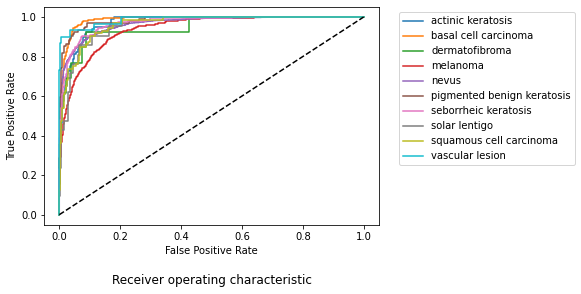

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

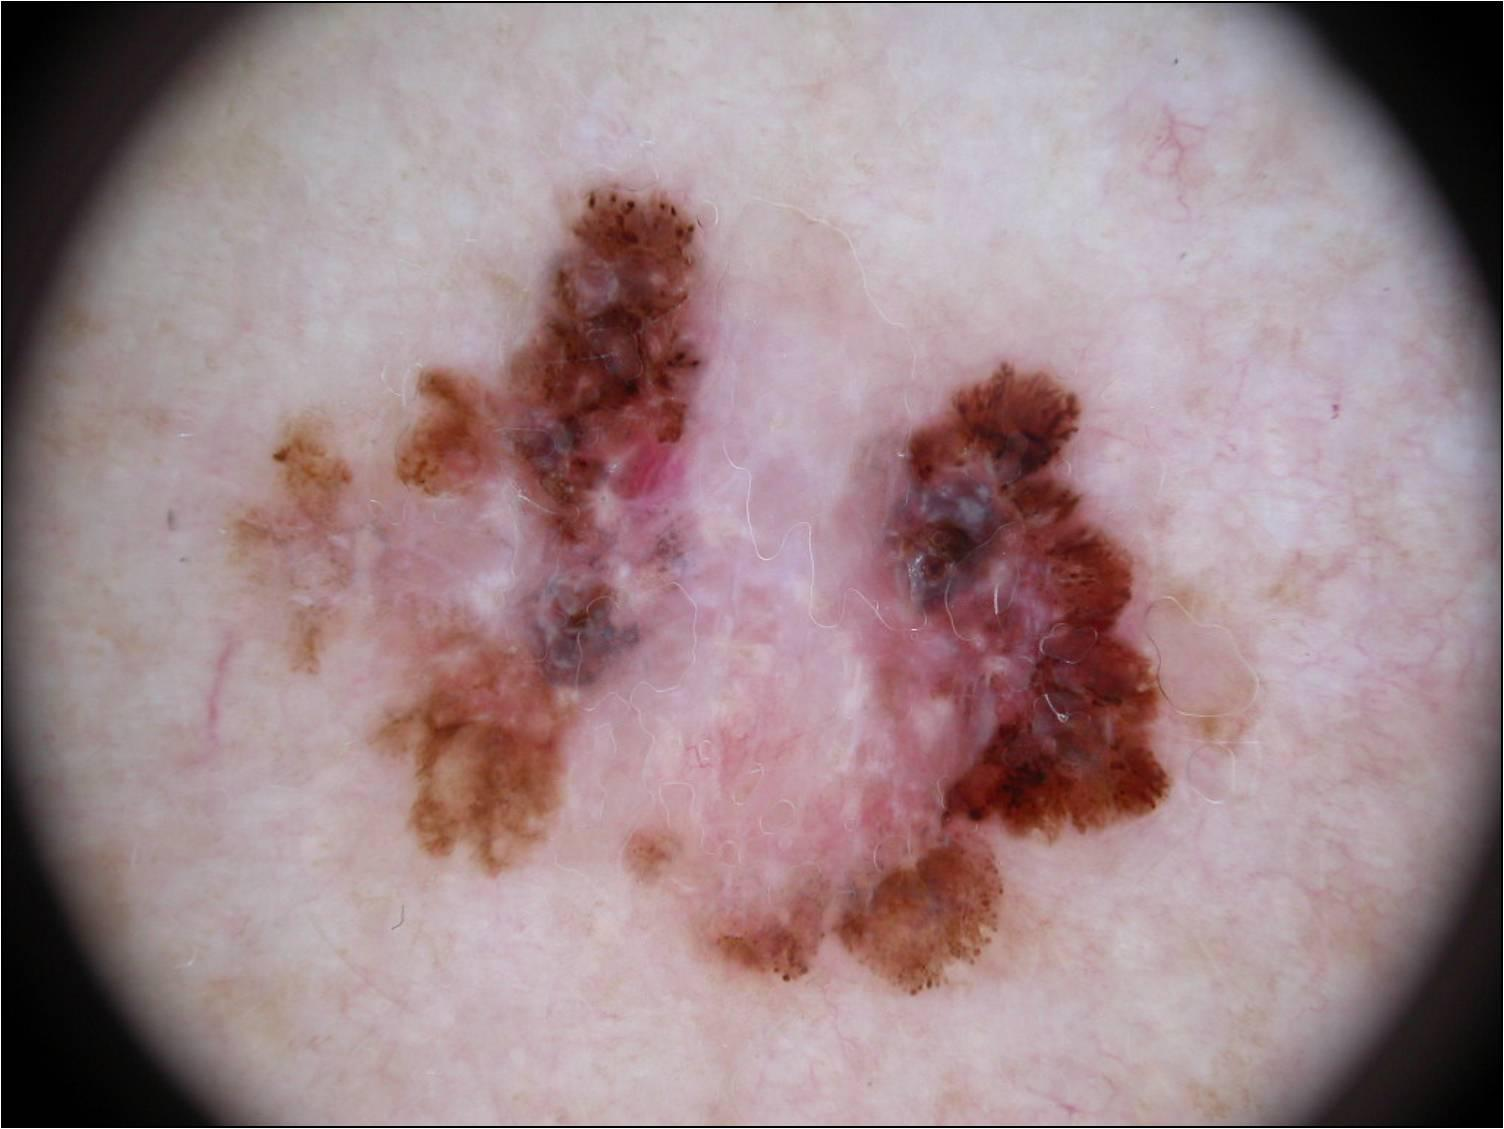

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

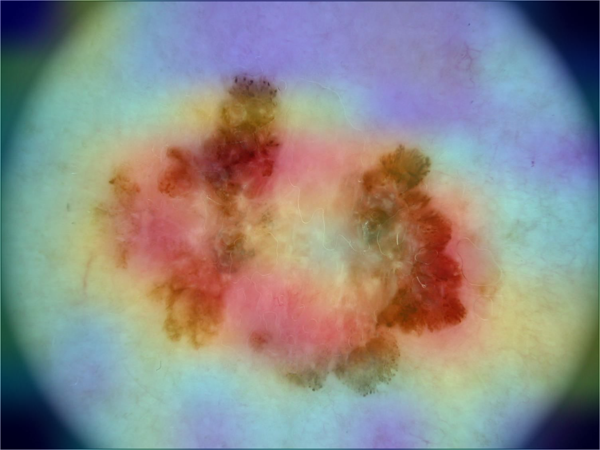

In [23]:
display_gradcam(melanoma_im_path, heatmap)